In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier)
from sklearn import metrics

DecisionTree with features [0, 1] has a score of 0.926667
RandomForest with 30 estimators with features [0, 1] has a score of 0.926667
ExtraTrees with 30 estimators with features [0, 1] has a score of 0.926667
AdaBoost with 30 estimators with features [0, 1] has a score of 0.840000
DecisionTree with features [0, 2] has a score of 0.993333
RandomForest with 30 estimators with features [0, 2] has a score of 0.993333
ExtraTrees with 30 estimators with features [0, 2] has a score of 0.993333
AdaBoost with 30 estimators with features [0, 2] has a score of 0.993333
DecisionTree with features [2, 3] has a score of 0.993333
RandomForest with 30 estimators with features [2, 3] has a score of 0.993333
ExtraTrees with 30 estimators with features [2, 3] has a score of 0.993333
AdaBoost with 30 estimators with features [2, 3] has a score of 0.993333


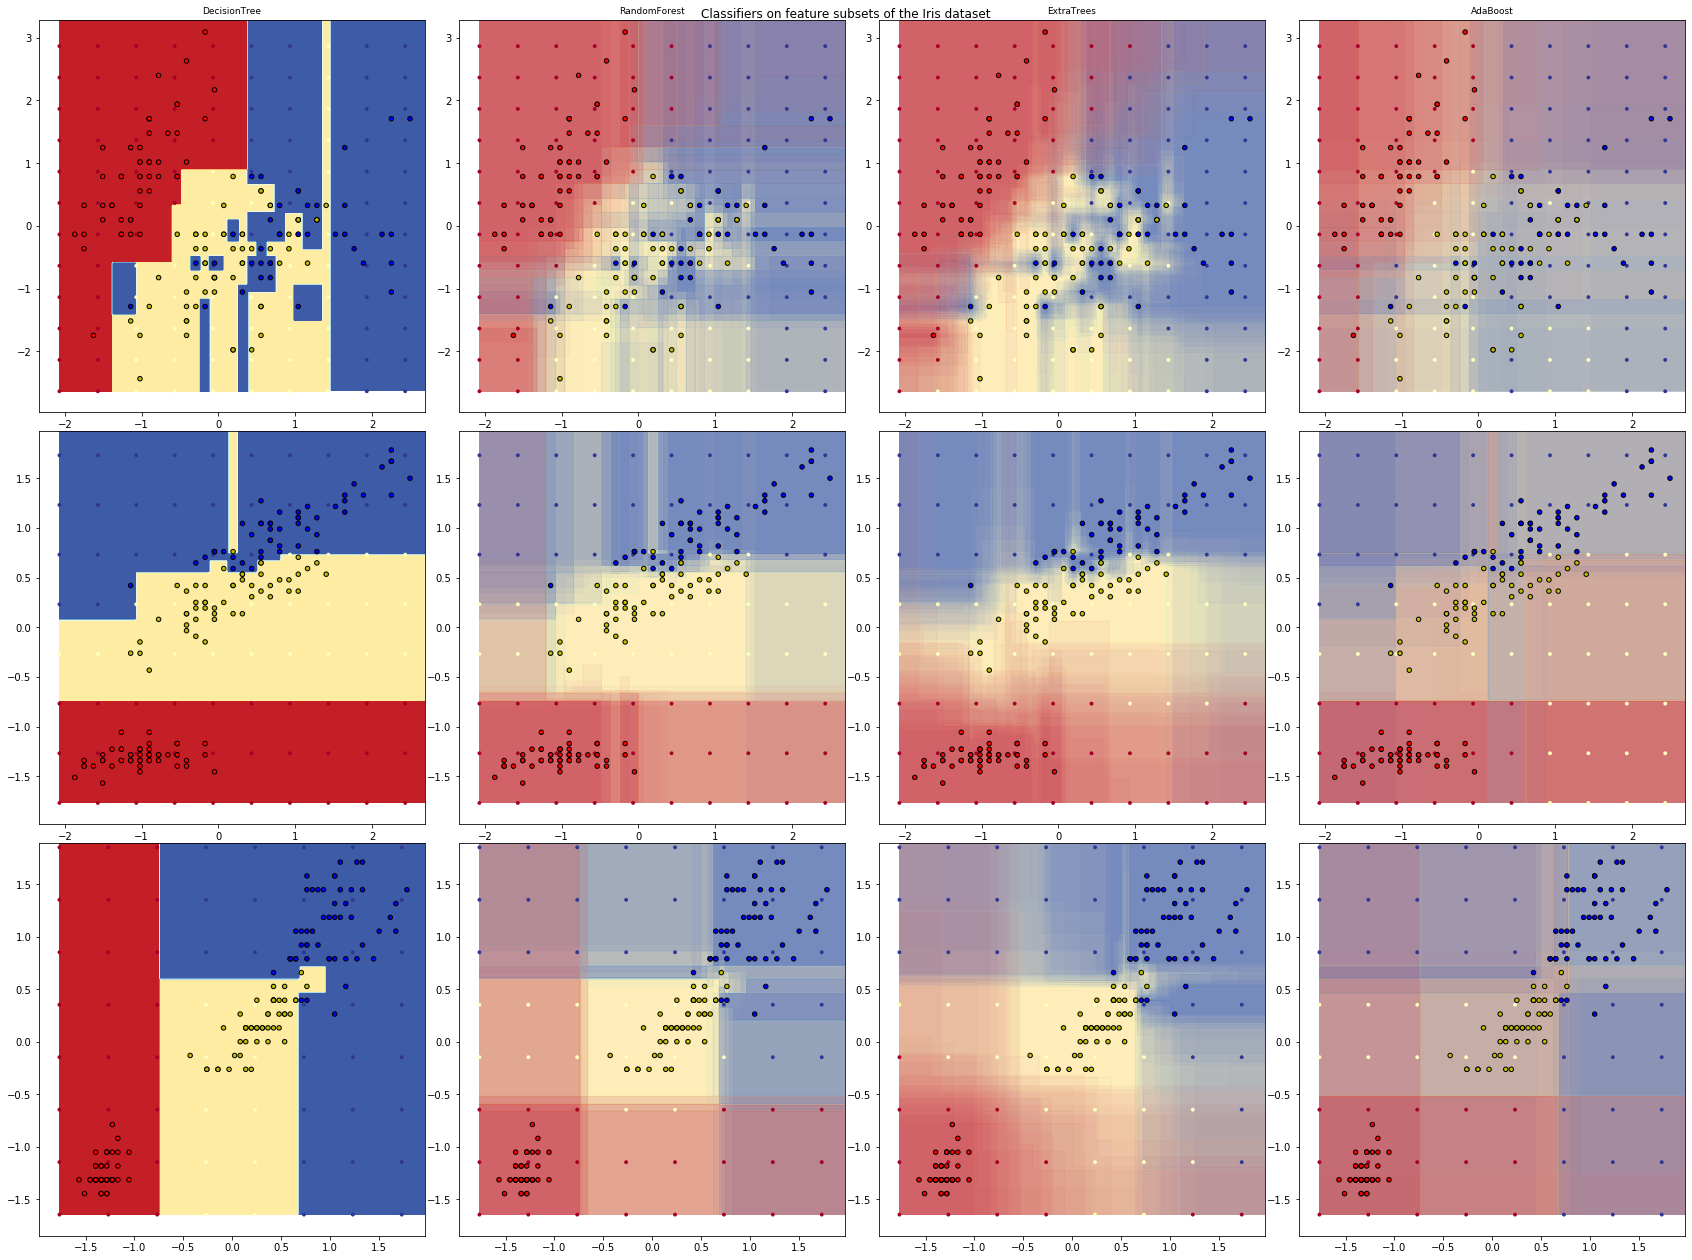

In [2]:
# Parameters
n_classes = 3
n_estimators = 30
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration

# Load data
iris = load_iris()

models = [DecisionTreeClassifier(max_depth=None),
          RandomForestClassifier(n_estimators=n_estimators),
          ExtraTreesClassifier(n_estimators=n_estimators),
          AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=n_estimators)]
# models = [DecisionTreeClassifier(max_depth=None),
#           RandomForestClassifier(n_estimators=n_estimators)]

# pairs = itertools.combinations(range(len(iris.feature_names)), 2)
# n = len(iris.feature_names) * (len(iris.feature_names) - 1) / 2
pairs = ([0, 1], [0, 2], [2, 3])
n = len(pairs)

plt.figure(figsize=(6 * len(models), 6 * n))

for i, pair in enumerate(pairs):
    for j, model in enumerate(models):
        X_train = iris.data[:, pair]
        y_train = iris.target

        # Shuffle
        idx = np.arange(X_train.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X_train = X_train[idx]
        y_train = y_train[idx]

        # Standardize
        mean = X_train.mean(axis=0)
        std = X_train.std(axis=0)
        X_train = (X_train - mean) / std

        # Train
        model.fit(X_train, y_train)
        scores = model.score(X_train, y_train)

        model_title = str(type(model)).split(".")[-1][:-2][:-len("Classifier")]
        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details = "%s with %d estimators" % (model_details, len(model.estimators_))
        print("%s with features %s has a score of %.6f" % (model_details, pair, scores))
        
        plot_idx = i * len(models) + j + 1
        plt.subplot(n, len(models), plot_idx)
        if plot_idx <= len(models):
            plt.title(model_title, fontsize=9)

        x_min = X_train[:, 0].min() - .2
        x_max = X_train[:, 0].max() + .2
        y_min = X_train[:, 1].min() - .2
        y_max = X_train[:, 1].max() + .2
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))

        if isinstance(model, DecisionTreeClassifier):
            z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            z = z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number
            # of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                z = z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a
        # black outline
        xx_coarser, yy_coarser = np.meshgrid(np.arange(x_min, x_max, plot_step_coarser), np.arange(y_min, y_max, plot_step_coarser))
        z_points_coarser = model.predict(np.c_[xx_coarser.ravel(), yy_coarser.ravel()]).reshape(xx_coarser.shape)
        cs_points = plt.scatter(xx_coarser, yy_coarser, s=15, c=z_points_coarser, cmap=cmap, edgecolors="none")

        # Plot the training points, these are clustered together and have a
        # black outline
        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=ListedColormap(['r', 'y', 'b']), edgecolor='k', s=20)

plt.suptitle("Classifiers on feature subsets of the Iris dataset", fontsize=12)
plt.axis("tight")
plt.tight_layout(h_pad=0.2, w_pad=0.2, pad=2.5)
plt.show()